In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.light14_hparams import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [3]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sun Mar  7 16:56:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
| 66%   58C    P2   208W / 370W |   6845MiB / 24268MiB |     82%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:68:00.0 Off |                  N/A |
| 30%   

In [4]:
save_dir = 'save/light14_model'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 0

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if False:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 32.7MiB
TTS size 26.3MiB
MelEncoder size 8.2MiB
MelDecoder size 16.1MiB
0
done


In [6]:
trainset = LJDataset(tts_hparams.root_dir)
collate_fn = TextMelCollate()
train_loader = torch.utils.data.DataLoader(trainset, num_workers=tts_hparams.num_workers, 
                          shuffle=True,
                          sampler=None,
                          batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)

print(train_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

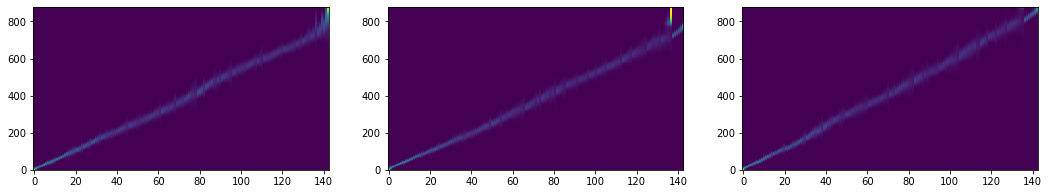

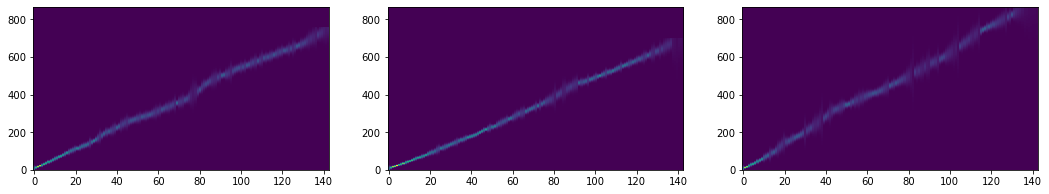

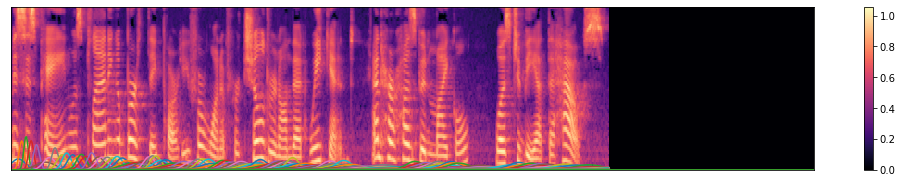

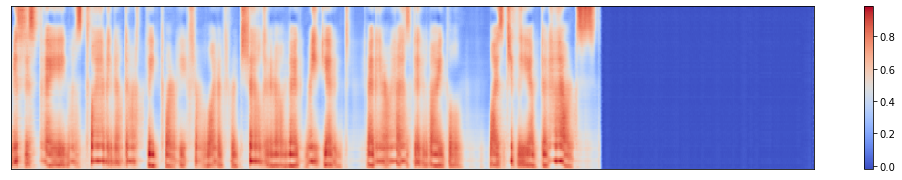

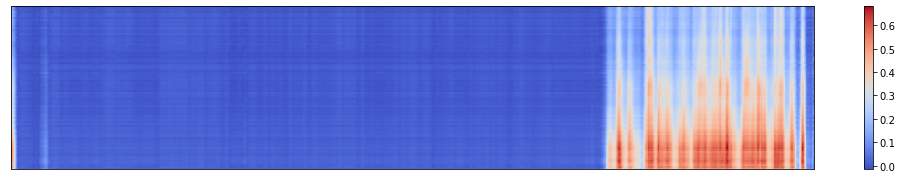

tensor(2.7427, device='cuda:0')
step : 2501 stt : 1.3461 tts : 1.5245 recon : 0.0037 kl : 0.0157 beta : 0.0500
tensor(5.6721, device='cuda:0')
step : 2502 stt : 1.1726 tts : 1.9002 recon : 0.0036 kl : 0.0157 beta : 0.0501
tensor(7.1345, device='cuda:0')
step : 2503 stt : 1.3792 tts : 1.4196 recon : 0.0037 kl : 0.0160 beta : 0.0501
tensor(1.9345, device='cuda:0')
step : 2504 stt : 1.1905 tts : 1.7584 recon : 0.0034 kl : 0.0149 beta : 0.0501
tensor(1.3999, device='cuda:0')
step : 2505 stt : 1.3044 tts : 1.4268 recon : 0.0034 kl : 0.0148 beta : 0.0501
tensor(4.3797, device='cuda:0')
step : 2506 stt : 1.2342 tts : 1.7104 recon : 0.0038 kl : 0.0158 beta : 0.0501
tensor(2.4210, device='cuda:0')
step : 2507 stt : 1.1450 tts : 1.9021 recon : 0.0033 kl : 0.0152 beta : 0.0502
tensor(1.5819, device='cuda:0')
step : 2508 stt : 1.2107 tts : 1.7521 recon : 0.0038 kl : 0.0158 beta : 0.0502
tensor(2.2583, device='cuda:0')
step : 2509 stt : 1.4209 tts : 1.2547 recon : 0.0037 kl : 0.0156 beta : 0.0502
t

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display


model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta.item())
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta.item())    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 3
            model.eval()
            with torch.no_grad():
                samples = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=0.7)

            _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
            batch_size = _tts_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
            batch_size = _stt_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 100)
                
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _y = tts_outputs['pred'].data.cpu().numpy()
            librosa.display.specshow(_y[index])
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _s = samples.data.cpu().numpy()
            librosa.display.specshow(_s[index, :, :_y.shape[2]])
            plt.colorbar()
            plt.show()
                      
        step += 1
        

In [8]:
logger.save(step, model, optimizer)

saved save/light3_model/save_18780


torch.Size([32, 80, 784]) 0.03007953882217407


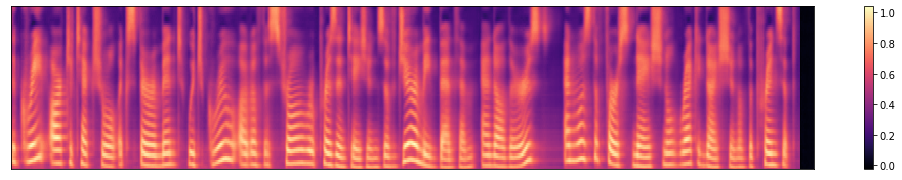

In [11]:
import numpy as np
import time 

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(100):
        t0 = time.time()
        samples = model.inference(batch['text'], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    
    plt.figure(figsize=[18, 3])
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()